# Single Particle Model (SPM): Fast discharge with concentration dependent diffusion 

In [2]:
# need to restart jupyter server? kernal? whenever a change is made to the pybamm module? 
import sys
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import integrate

os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm
print(pybamm.__path__[0])
%matplotlib widget


c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


In [143]:
from pybamm import exp, constants, Parameter


def modified_graphite_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Negative electrode diffusion coefficient [m2.s-1]")
    # D_ref = 16*5.0 * 10 ** (-15)
    E_D_s = 42770/100
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    # soc = (sto - 0.036)/(0.842-0.036)
    soc = (sto - 0)/(0.8321-0)


    # k = -11.79206386*soc**3 + 19.74642427*soc**2 -9.58613417*soc + 2.18105841 #fitted without thermal model
    # k = 0.86610992*soc + 0.15162466 #11?
    # k = 0.99*soc + 0.01 #
    k = 0.86681782*soc + 0.16565809 #13
    # k = 1
    # p_high = -15.88891693*soc**3 + 32.73897665*soc**2 -22.08987841*soc + 5.8916456 # high SOC
    # p_low = 15.47540036*soc**2 -10.8508352*soc + 2.13736774 # low SOC
    # k = p_high*(1/(1 + exp(-(soc-0.4)*150)))+ p_low*(1-1/(1 + exp(((0.4-soc)*150))))

    # Ds11
    # p_high = 1.3792875#-15.85192692*soc**3 + 34.1354626*soc**2 -23.71872136*soc + 6.33107728 # high SOC
    # p_low = 0.23807837 #0.35006582 # low SOC
    # # p_high = -0.9128685*soc + 1.95773523
    # # p_low = -1.40355492 + 0.68102741
    # k = p_high*(1/(1 + exp(-(soc-0.4)*20)))+ p_low*(1-1/(1 + exp(((0.4-soc)*20))))

    return D_ref*1#k*arrhenius # *(-0.9 * sto + 1)

def modified_NMC_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Positive electrode diffusion coefficient [m2.s-1]")
    E_D_s = 18550/10
    soc = (0.837-sto)/(0.837-0.034)
    # k = 3.77967906*soc**2 - 3.54525492*soc + 1.04220164 # 8 fitted with thermal model 
    # k = 3.73478491*soc**2 - 3.50522373*soc + 1.03247363 # 8?fitted without thermal model
    # k = 2.61225029*soc**2 - 2.17500416*soc + 0.69677927 # 13 fitted with thermal model    
    k = 5.73752909*soc**2 - 5.65715456*soc + 1.51876706 # 103 fitted with isothermal spme  
    # k = 5.73752909*soc**2 -5.65715456*soc + 1.51876706 # 104 fitted with isothermal spme [ 5.73752909 -5.65715456  1.51876706] 

    # k = 1.73857835*soc**2 -0.95867106*soc + 0.29889581 # 9 removing high error fits. fitted without thermal model
    # k =  3.32316507*soc**2 -3.06075959*soc + 0.94787949 # 11 removing high error fits k0=[SOC_0]*2
    # k = 0.62889645*soc +0.08790276

    # p_high = -7.54090264*soc**3 +17.18863735*soc**2 -10.57421123*soc + 1.97512672 # high SOC
    # p_low = 6.12915318*soc**2 -4.58479402*soc + 1.06832757# low SOC
    # k = p_high*(1/(1 + exp(-(soc-0.6)*150)))+ p_low*(1-1/(1 + exp(((0.6-soc)*150))))
    # arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
    
    return D_ref *k

def modified_electrolyte_diffusivity_PeymanMPM(c_e, T):
    # D_c_e = 5.35 * 10 ** (-10)
    D_c_e =  Parameter("Typical electrolyte diffusivity [m2.s-1]")
    E_D_e = 37040
    # arrhenius = exp(E_D_e / constants.R * (1 / 298.15 - 1 / T))
    # k = Parameter("Electrolyte diffusion scalar")
    # k_T =  1/(1 + exp(-10*((114+273.15)-T))*(1-0.5)+0.5)
    # k_T=1
    # D_c_e = 8.794e-11 * (c_e/ 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    # k_T =  pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    return D_c_e#*arrhenius

def modified_electrolyte_conductivity_PeymanMPM(c_e, T):
    # sigma_e = 1.3
    sigma_e = Parameter("Typical electrolyte conductivity [m2.s-1]")
    E_k_e = 34700
    # arrhenius = exp(E_k_e / constants.R * (1 / 298.15 - 1 / T))

    # k_T = 1*(1/(1 + exp(-(T-(114+273.15))*150)))+ 1*(1-1/(1 + exp(((114+273.15)-T)*150)))
    # k_T =  1#pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    # k_T =  1/(1 + exp(-5*((114+273.15)-T))*(1-0.9)+0.9)
    return sigma_e#*k_T# (1-k)#*arrhenius

def P_sat(T):
    P_dmc = 10**((6.4338-1413.0)/(T-44.25))
    P_ec = 10**((6.4897-1836.57)/(T-102.23))
    P = P_ec + P_dmc 
    return P

In [144]:
SOC_0 = 1
SOC_name = SOC_0
Q_nom = 4.6

# load data import ESC data from file
data = pd.read_csv(
    "./fast_discharge/2C_pulse_test_data_DCR_Cell_43.csv"#, comment="#", header=None
)

# current profile for running sim
pulse_current = data[['time_s', 'I_A']].to_numpy()

# load data import ESC data from file
# esc_start = raw_data[-raw_data['I_A']>1].index[0]
# esc_end = raw_data[raw_data['Time (s)']>15*60].index[0]
# esc_end =len(raw_data)
# T_amb = np.mean(raw_data['Cell Temperature'][(raw_data.index < esc_start) & (raw_data['Cell Temperature'] >0)])
# data = raw_data[raw_data.keys()].loc[esc_start:esc_end].copy()
df_labels = ['t', 'V', 'mAh', 'Temp','Q', 'I']
data.set_axis(df_labels, axis=1, inplace=True)
data['I_C'] = data.I/Q_nom 
AhT_calculated = integrate.cumtrapz(abs(data.I), data.t-data.t.iloc[0])/3600
AhT_calculated = np.append(AhT_calculated,AhT_calculated[-1])
data['SOC'] = SOC_0 - AhT_calculated/Q_nom
T_amb = data.Temp.iloc[0]
data = data[np.where(data.I>1)[0][0]-1::]
data.t = data.t-data.t.iloc[0]

# Run nominal model 

In [145]:
solutions = []

h =  5 #
Cp = 1.51997699  # # set up and solve model
solutions = []
options = {
    # "thermal": "x-lumped",
    # "intercalation kinetics": "high-current Butler-Volmer",
    #         "side reactions": "decomposition", 
}
model = pybamm.lithium_ion.SPMe(options = options)
param = pybamm.ParameterValues(pybamm.parameter_sets.Mohtat2020)
# t_initial_rest = data.t[np.where(data.I>1)[0][0]]
param.update({
    "Lower voltage cut-off [V]": 0,
    "Nominal cell capacity [A.h]": 4.6,
    "Typical current [A]":4.6,
    "Negative tab width [m]":2.5e-2,
    "Positive tab width [m]":2.5e-2,
    "Negative electrode thickness [m]":62E-06*4.2/5,
    "Positive electrode thickness [m]":67E-06*4.2/5,
    "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Negative tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Positive tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Edge heat transfer coefficient [W.m-2.K-1]":5,
    "Total heat transfer coefficient [W.m-2.K-1]":5,
    "Negative electrode diffusivity [m2.s-1]": 8.0E-14, 
    "Positive electrode diffusivity [m2.s-1]": 8.0E-15, 
    "Ambient temperature [K]": 23+273.15,
    "Initial temperature [K]": 23 + 273.15,
    "Typical electrolyte diffusivity [m2.s-1]":5.35E-10,
    "Typical electrolyte conductivity [m2.s-1]":1.3*10,

}, check_already_exists = False)
experiment = pybamm.Experiment(
        #  ["Rest for {:.4f} minute".format(t_initial_rest/60-0.15),]+ 
        [
        # "Run pulse (A) until 3.0 V", 
        ("Discharge at 1.95 C for 2 minutes or until 2.8 V", 
        "Rest for 5 minutes",) 

        ]*14,
        drive_cycles={
            'pulse': pulse_current
        }, period = "1 second"
    )
solver = pybamm.CasadiSolver(mode="safe") #, extra_options_setup={"max_num_steps": 10000}
sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param, solver= solver)
solution = sim.solve( initial_soc=SOC_0)
solutions.append(solution)

# Run simulation with fitted values

In [146]:
param.update({
    "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
    "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM, #8E-15 
}, check_already_exists = False)

solver = pybamm.CasadiSolver(mode="safe", dt_max = 10) #, extra_options_setup={"max_num_steps": 10000}
sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param, solver=solver)
solution1 = sim.solve( initial_soc=SOC_0)
solutions.append(solution1)

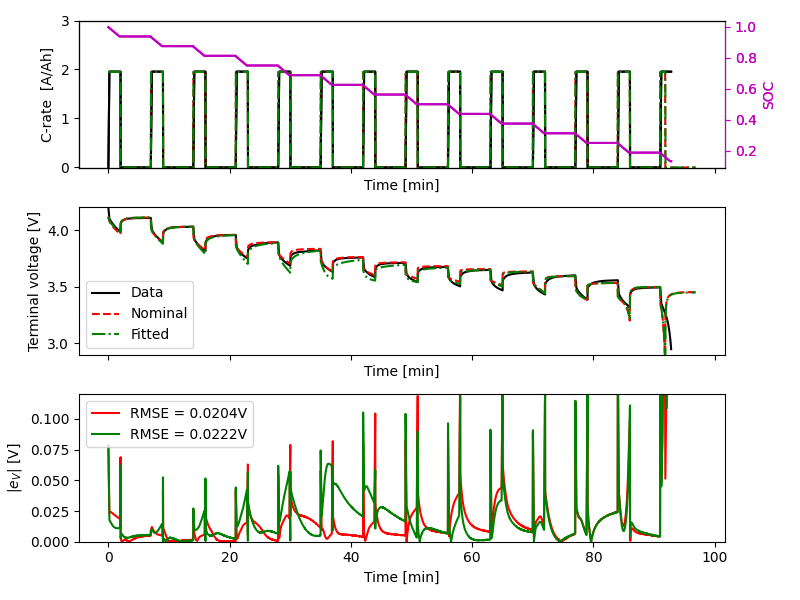

In [147]:
%matplotlib widget

# fig, ax = plt.subplots(3, 1, figsize=(4,6), sharex=True)
fig, ax = plt.subplots(3, 1, figsize=(8,6), sharex=True)

ax = ax.flatten()
linestyles = ['--','-.',':']*2
sim_colors = ['r','g','b','m']
for l, solution in enumerate(solutions):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t/60
    xlabel = "Time [min]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = 'k'
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    ax[0].plot(data.t/60,data.I/param['Nominal cell capacity [A.h]'], label='Data', color = data_color)
    ax[0].plot(x_plot, I(t), linestyle=sim_ls, color = sim_color)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate  [A/Ah]')
    ax[0].set_ylim([-0.01,3])
    ax2 = ax[0].twinx()
    ax2.plot(data.t/60,data.SOC, color = 'm')
    ax2.set_ylabel('SOC', color = 'm')
    ax2.tick_params(axis='y', color='m', labelcolor='m')
    ax2.spines['right'].set_color('m')


    V = solution['Terminal voltage [V]']
    if l ==0:
        ax[1].plot(data.t/60, data.V,color = data_color)
    ax[1].plot(x_plot, V(t),linestyle=sim_ls, color = sim_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Terminal voltage [V]')
    ax[1].set_ylim([2.9,4.2])
    handles = ['Data', 'Nominal','Fitted']
    ax[1].legend(handles) #, bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10}


    # T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    # ax[2].plot(data['time_s']/60, data['Temperature__C'],color = data_color)
    # ax[2].plot(x_plot, T,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[2].set_xlabel(xlabel)
    # ax[2].set_ylabel('Temperature [$^\circ$C]')

    # c_n_avg = solution['R-averaged negative particle concentration']
    # c_p_avg = solution['R-averaged positive particle concentration']
    # x = solution["x [m]"].entries[:, 0]
    # ax[1,0].plot(x_plot, c_n_avg(t=t, x=x[0]),linestyle='-', color = sim_color, label = "$c_{n,avg}$" )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,0].plot(x_plot, c_p_avg(t=t, x=x[-1]),linestyle=':', color = sim_color, label = "$c_{p,avg}$" )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,0].set_xlabel(xlabel)
    # ax[1,0].set_ylabel('$c_{avg,n}$ and $c_{avg,p}$')
    # ax[1,0].legend(loc = 'center right')

    # calculate and print errors
    t_error = data.t[data.V>3].to_numpy()
    rmse_I = np.sqrt(np.mean(np.square(data.I[data.V > 3.0]- I(t_error))))
    # print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
    rmse_V = np.sqrt(np.mean(np.square(data.V[data.V > 3.0]- V(t_error))))
    # print('RMSE V: ' + str(round(rmse_V,5)))
    e_V = abs(data.V[data.V > 3.0] - V(data.t[data.V > 3.0]))
    ax[2].plot(data.t[data.V > 3.0]/60, e_V,color = sim_color, label = 'RMSE = ' + str(np.round(rmse_V,4)) + 'V')  # can evaluate at arbitrary x (single representative particle)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('|$e_V$| [V]')
    ax[2].legend(loc = 'upper left')
    ax[2].set_ylim([0,0.12])

    # Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
    # Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
    # ax[1,2].plot(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].plot(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
    # ax[1,2].legend(loc = 'center right')
    # t_error = data['time_s'][data.Ecell_V > 3.0].to_numpy()

# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
plt.tight_layout()
plt.show()

plt.savefig('./fast_discharge/figs/pulse_validation.jpg', format='jpg')

KeyError: 'time_s'

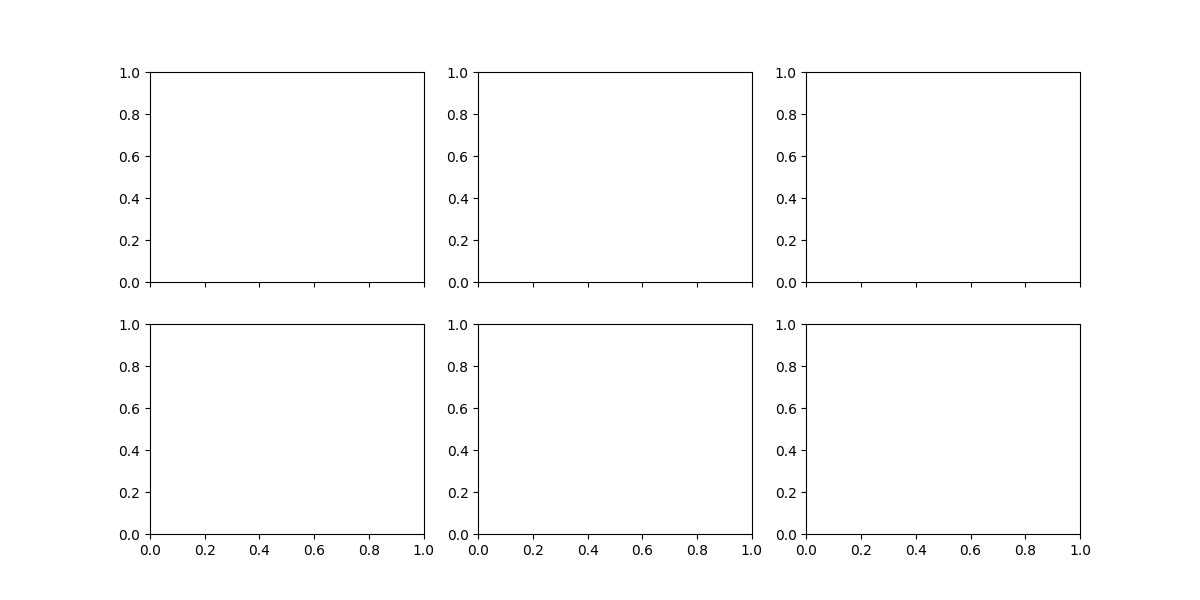

In [132]:
%matplotlib widget

fig, ax = plt.subplots(2, 3, figsize=(12,6), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','.-']*2
sim_colors = ['r','g','b','m']
for l, solution in enumerate(solutions):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t/60
    xlabel = "Time [min]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = 'k'
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    ax[0,0].plot(data['time_s']/60,data['I_A']/param['Nominal cell capacity [A.h]'], label='Data', color = data_color)
    ax[0,0].plot(x_plot, I(t), linestyle=sim_ls, color = sim_color)
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('C-rate')


    V = solution['Terminal voltage [V]']
    if l ==0:
        ax[0,1].plot(data['time_s']/60, data['Ecell_V'],color = data_color)
    ax[0,1].plot(x_plot, V(t),linestyle=sim_ls, color = sim_color)
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Terminal voltage [V]')
    ax[0,1].set_ylim([3,4.2])
    handles = ['Data', 'Nominal diffusivity','Fitted diffusivity']
    ax[0,1].legend(handles) #, bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10}


    T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    ax[0,2].plot(data['time_s']/60, data['Temperature__C'],color = data_color)
    ax[0,2].plot(x_plot, T,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[0,2].set_xlabel(xlabel)
    ax[0,2].set_ylabel('Temperature [$^\circ$C]')

    c_n_avg = solution['R-averaged negative particle concentration']
    c_p_avg = solution['R-averaged positive particle concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[1,0].plot(x_plot, c_n_avg(t=t, x=x[0]),linestyle='-', color = sim_color, label = "$c_{n,avg}$" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].plot(x_plot, c_p_avg(t=t, x=x[-1]),linestyle=':', color = sim_color, label = "$c_{p,avg}$" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel('$c_{avg,n}$ and $c_{avg,p}$')
    ax[1,0].legend(loc = 'center right')

    # calculate and print errors
    rmse_I = np.sqrt(np.mean(np.square(data['I_A'][data.Ecell_V > 3.0]- I(t_error))))
    # print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
    rmse_V = np.sqrt(np.mean(np.square(data['Ecell_V'][data.Ecell_V > 3.0]- V(t_error))))
    # print('RMSE V: ' + str(round(rmse_V,5)))
    e_V = abs(data['Ecell_V'] - V(data['time_s']))
    ax[1,1].plot(data['time_s']/60, e_V,color = sim_color,label = 'RMSE = ' + str(np.round(rmse_V,4)))  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('|$e_V$|')
    ax[1,1].legend(loc = 'upper center')

    Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
    Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
    ax[1,2].plot(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].plot(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
    ax[1,2].legend(loc = 'center right')
    t_error = data['time_s'][data.Ecell_V > 3.0].to_numpy()

# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
plt.tight_layout()
plt.show()


In [ ]:
display([k for k in model.variables.keys()])

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Throughput capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosity',
 'X-averaged separator porosity',
 'X-averaged positive electrode porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Leading-order porosity',
 'Leading-order separator porosity',
 'Leading-order positive electrode porosity',
 'Leading-order x-averaged separator porosity',
 'Leading-order x-averaged positive electrode porosity',
 'Leading-order negative electrode porosity',
 'Leading-order x-averaged negative electrode porosity',
 'Porosity change',
 'Separator porosity change',
 'Positive elect

Some of the output variables are defined over space as well as time. Once option to visualise these variables is to use the `interact` slider widget. Below we plot the negative/positive particle concentration over $r$, using a slider to change the current time point

The QuickPlot class can be used to plot the common set of useful outputs which should give you a good initial overview of the model. The method `Quickplot.dynamic_plot` employs the slider widget.  

In [ ]:
%matplotlib inline
solution = solutions[0]
quick_plot = pybamm.QuickPlot(solution)
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1.555098397225307, step=0.015550983972253069…

## Dimensionless Parameters

interactive(children=(FloatSlider(value=0.0, description='t', max=3600.0, step=10.0), Output()), _dom_classes=…

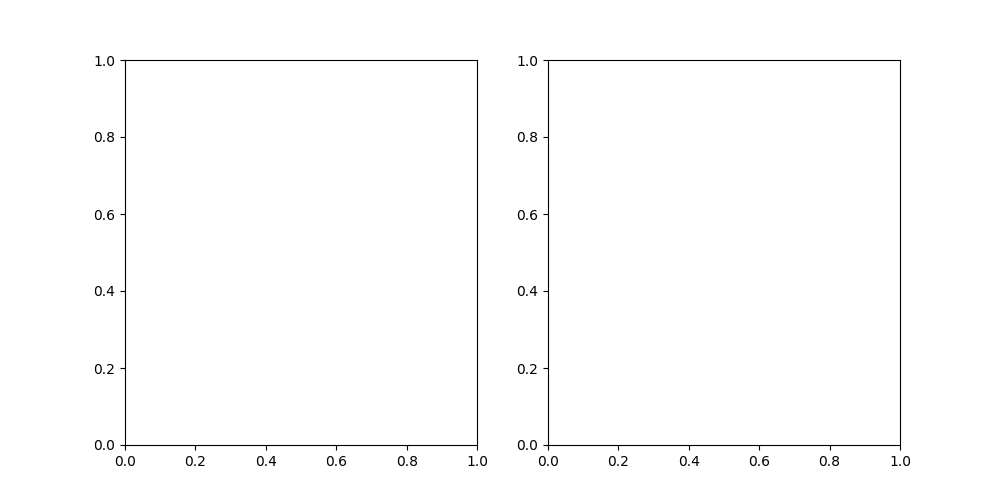

In [20]:
c_s_n = solution['Negative particle concentration']
c_s_p = solution['Positive particle concentration']
r_n = solution["r_n [m]"].entries[:, 0, 0]
r_p = solution["r_p [m]"].entries[:, 0, 0]

def plot_concentrations(t):
    f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,5))
    plot_c_n, = ax1.plot(r_n, c_s_n(r=r_n,t=t,x=x[0]))  # can evaluate at arbitrary x (single representative particle)
    plot_c_p, = ax2.plot(r_p, c_s_p(r=r_p,t=t,x=x[-1]))  # can evaluate at arbitrary x (single representative particle)
    ax1.set_ylabel('Negative particle concentration')
    ax2.set_ylabel('Positive particle concentration')
    ax1.set_xlabel(r'$r_n$ [m]')
    ax2.set_xlabel(r'$r_p$ [m]')
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    plt.show()
    
import ipywidgets as widgets
widgets.interact(plot_concentrations, t=widgets.FloatSlider(min=0,max=3600,step=10,value=0));


## References

The relevant papers for this notebook are:

In [10]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[4] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[5] Charles

In [11]:
param.search('Diffusivity')

EC diffusivity [m2.s-1]	2e-18
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_PeymanMPM at 0x00000260F04EDF70>
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Negative electrode diffusivity [m2.s-1]	<function modified_graphite_diffusivity_PeymanMPM at 0x00000260F02B0940>
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Positive electrode diffusivity [m2.s-1]	<function modified_NMC_diffusivity_PeymanMPM at 0x00000260F02D39D0>
Typical electrolyte diffusivity [m2.s-1]	8.025000000000001e-10
